In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

import torch
from matplotlib import pyplot as plt
import scipy.io as io
import numpy as np
import sys
import random
import pandas as pd
import torch.nn.functional as F
import six
import math
from scipy.signal import hilbert2
import time

sys.path.append("..")
from utils import flow_warp
from utils.losses import *
from utils.tools import *


def save_mat(path,name):#存储成mat
    io.savemat(path, name)
def to_bmode(image):
    return np.log(np.abs(np.imag(hilbert2(np.squeeze(image))))+0.01)
def upsample_kernel2d(w, device):
    c = w // 2
    kernel = 1 - torch.abs(c - torch.arange(w, dtype=torch.float32, device=device)) / (c + 1)
    kernel = kernel.repeat(w).view(w,-1) * kernel.unsqueeze(1)
    return kernel.view(1, 1, w, w)


def downsample_kernel2d(w, device):
    kernel = ((w + 1) - torch.abs(w - torch.arange(w * 2 + 1, dtype=torch.float32, device=device))) / (2 * w + 1)
    kernel = kernel.repeat(w).view(w,-1) * kernel.unsqueeze(1)
    return kernel.view(1, 1, w * 2 + 1, w * 2 + 1)


def Upsample(img, factor):
    if factor == 1:
        return img
    B, C, H, W = img.shape
    batch_img = img.view(B*C, 1, H, W)
    batch_img = F.pad(batch_img, [0, 1, 0, 1], mode='replicate')
    kernel = upsample_kernel2d(factor * 2 - 1, img.device)
    upsamp_img = F.conv_transpose2d(batch_img, kernel, stride=factor, padding=(factor-1))
    upsamp_img = upsamp_img[:, :, : -1, :-1]
    _, _, H_up, W_up = upsamp_img.shape
    return upsamp_img.view(B, C, H_up, W_up)
def standardization(data):
        mu = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        return (data - mu) / (sigma +1e-8)

def max_standardization(data):
        return (data - np.min(data)) / (np.max(data)-np.min(data)+1e-8)

def get_patches(x, x_wind=143):
    kh, dh = (x_wind*2)+1, 1
    patches = x.unfold(2, kh, dh)
    # print('x.shape='+str(x.shape)+' patches.shape='+str(patches.shape))
    patches = torch.squeeze(patches,dim=1).permute(0,1,3,2)
    return patches


def get_strain_guss(disp, x_wind=51):
    from scipy import signal
    from scipy.ndimage import gaussian_filter
    # d = x_wind*2+1
    # Uxx_list = []
    # disp = get_patches(disp,x_wind=x_wind)
    # depthX = torch.linspace(1,d,d)
    # depthX = torch.stack([depthX,torch.ones_like(depthX)]).float().permute(1,0).type_as(disp)
    # depthX = depthX.unsqueeze(0).repeat(disp.shape[1],1,1)
    # XtX = depthX.permute(0,2,1).bmm(depthX)
    # for i in range(len(disp)):
    #     # Cholesky decomposition
    #     XtY = depthX.permute(0,2,1).bmm(disp[i,...])
    #     betas_cholesky, _ = torch.solve(XtY, XtX)
    #     Uxx = torch.squeeze(betas_cholesky[:,0,:])
    #     # pad to original size
    #     Uxx_list += [F.pad(Uxx, (0,0,x_wind, x_wind))]
    # return torch.stack(Uxx_list).unsqueeze(1)
    disp = np.squeeze(disp)
    strain = gaussian_filter(disp.cpu().detach().numpy(), sigma=[24,3])
    strain = signal.convolve2d(strain, np.array([[1],[0],[-1]]))
    return strain[30:-60,15:-15]

def get_strain_cholesky(disp, x_wind=51):
    d = x_wind * 2 + 1
    Uxx_list = []
    disp = get_patches(disp, x_wind=x_wind)
    depthX = torch.linspace(1, d, d)
    depthX = torch.stack([depthX, torch.ones_like(depthX)]).float().permute(1, 0).cuda()
    depthX = depthX.unsqueeze(0).repeat(disp.shape[1], 1, 1)
    XtX = depthX.permute(0, 2, 1).bmm(depthX)
    for i in range(len(disp)):
        # Cholesky decomposition
        XtY = depthX.permute(0, 2, 1).bmm(disp[i, ...])
        betas_cholesky = torch.linalg.solve(XtX, XtY)  # 使用 torch.linalg.solve 替代 torch.solve
        Uxx = torch.squeeze(betas_cholesky[:, 0, :])
        # pad to original size
        Uxx_list += [F.pad(Uxx, (0, 0, x_wind, x_wind))]
    return torch.stack(Uxx_list).unsqueeze(1)

def warp_image(x, ddf):
    B, _, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
    yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
    xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    grid = torch.cat((xx ,yy) ,1).float()

    # print('x.device:',str(x.device))
    # print('ddf.device:',str(ddf.device))

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + ddf

    # scale grid to [-1,1]
    vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
    vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

    vgrid = vgrid.permute(0 ,2 ,3 ,1) 
    output = F.grid_sample(x, vgrid)

    # 以下为增加部分（mask）
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = F.grid_sample(mask, vgrid)

    mask[mask<0.9999] = 0
    mask[mask>0] = 1

    return (output*mask)

def nrmse(outputs, targets):
    """
    Normalized root-mean square error
    :param outputs: Module's outputs
    :param targets: Target signal to be learned
    :return: Normalized root-mean square deviation
    """
    # Flatten tensors
    outputs = outputs.view(outputs.nelement())
    targets = targets.view(targets.nelement())

    # Check dim
    if outputs.size() != targets.size():
        raise ValueError(u"Ouputs and targets tensors don have the same number of elements")
    # end if

    # Normalization with N-1
    var = targets 

    # Error
    error = targets - outputs

    # Return
    return float(math.sqrt(torch.mean(error **2)) / (math.sqrt(torch.mean(var **2)) + 1e-8))

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        _, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax
def cnr(img1, img2):
    return np.abs((img1.mean() - img2.mean()))/ np.sqrt(img1.var() + img2.var())


def snr(img):
    return img.mean() / img.std()

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def normalized(data, ymin=-1, ymax=1):
    min_data = data.min()
    max_data = data.max()
    data = (ymin-ymax)*(data-min_data)/(max_data-min_data)+ymax
    return data

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cutModel

In [ ]:
from Models.pwcnetCut import PWCNet
import torch_pruning as tp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# path ="/202222000580/ChaoSuan_results/secondArticle/Distill/model/panthom/300_model_stu.pth" #RF,Env,BM model path
data_path = '/Data_121706/'


model = PWCNet().to(device)
state_dict = torch.load("/stu/220_net_PWCNet.pth")
tp.load_state_dict(model, state_dict=state_dict)
model.load_state_dict(torch.load("/Distill/40_model_stu.pth"))
model = model.to(device)
print(model)

# model.load_state_dict(torch.load(path))
model.eval()

/202222000580/qulify_test/Models/pwcnetCut.py:96: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_in')


PWCNet(
  (conv1a): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3b): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv6aa): Sequential(
    (0): Conv2d(64, 98, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )


PWCNet(
  (conv1a): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3b): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv6aa): Sequential(
    (0): Conv2d(64, 98, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )


model time cost:------->5.2471


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


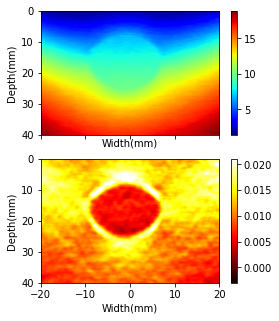

Data_1338 SNRt is 12.549991607666016 / SNRb is 9.321346282958984 / CNR is 5.102792739868164  NCC is 0.9330418705940247
model time cost:------->0.1850


<Figure size 432x288 with 0 Axes>

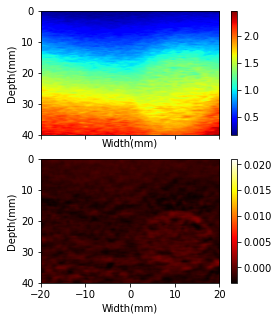

Data_2882 SNRt is 4.117307186126709 / SNRb is 7.646450042724609 / CNR is 3.004359722137451  NCC is 0.939771831035614
model time cost:------->0.1845


<Figure size 432x288 with 0 Axes>

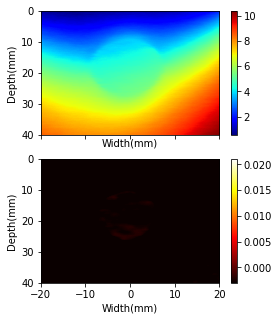

Data_673 SNRt is 14.426872253417969 / SNRb is 13.238016128540039 / CNR is 6.932952880859375  NCC is 0.9434407949447632
model time cost:------->0.1849


<Figure size 432x288 with 0 Axes>

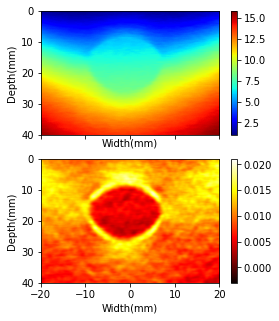

Data_1342 SNRt is 13.017253875732422 / SNRb is 11.021230697631836 / CNR is 4.636741638183594  NCC is 0.9415364265441895
model time cost:------->0.1864


<Figure size 432x288 with 0 Axes>

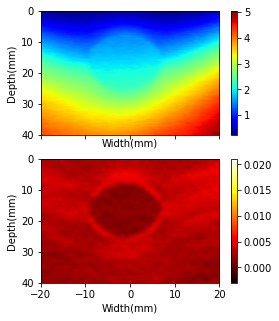

Data_1103 SNRt is 13.180118560791016 / SNRb is 9.748339653015137 / CNR is 5.141875743865967  NCC is 0.9622930288314819
model time cost:------->0.1854


<Figure size 432x288 with 0 Axes>

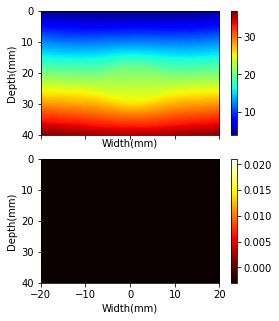

Data_3531 SNRt is 24.785871505737305 / SNRb is 8.138102531433105 / CNR is 1.1135289669036865  NCC is 0.9570386409759521
model time cost:------->0.1850


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:

patch_H = 32
patch_W = 32
list_data_id = ['Data_1338','Data_2882','Data_673','Data_1342',
                'Data_1726']
df = pd.DataFrame(columns=['image_id','SNRt','SNRb','CNR','NCC_mean']) # result_analysis
# df = pd.DataFrame(columns=['image_id','NCC']) # result_analysis
location = {
    'Data_1338':[750,180],
    'Data_2882':[1100,275],
    'Data_673':[800,200],
    'Data_1342':[750,180],
    'Data_1726':[1250,190]
}
back_location = {
    'Data_1338':[[325,200],[1150,200]],
    'Data_2882':[[550,280],[1600,280]],
    'Data_673':[[400,200],[1175,200]],
    'Data_1342':[[200,200],[1175,200]],
   
    'Data_1726':[[750,200],[1750,200]]
}
for ID in list_data_id:

    ##RF
    data = io.loadmat(data_path + ID +'.mat')
    # H = data['bm'].shape[1]
    # W = data['bm'].shape[2]

    H = data['Data'].shape[1]
    W = data['Data'].shape[2]
    
    ############RF
    SNRb_list = []
    SNRt_list = []
    CNR_list = []
    NCC_list = []
    # img = np.zeros((2,3,1920,384),dtype=np.float32)
    img = np.zeros((1,2,1920,384),dtype=np.float32)

   
    # img[0,0,:,:] = data['Data'][0,:H,:W]
    # img[0,1,:,:] = data['Data'][0,:H,:W]
    # img[0,2,:,:] = data['Data'][0,:H,:W]

    # img[1,0,:,:] = data['Data'][1,:H,:W]
    # img[1,1,:,:] = data['Data'][1,:H,:W]
    # img[1,2,:,:] = data['Data'][1,:H,:W]


    img[0,0,:,:] = data['Data'][0,:H,:W]
    img[0,1,:,:] = data['Data'][1,:H,:W]
    # img[0,:,:] = data['bm'][0,:H,:W]
    # img[1,:,:] = data['bm'][1,:H,:W]

    img = normalized(img)
   
    # img[0,0,:,:] = normalized(img[0,0,:,:])
    # img[0,1,:,:] = normalized(img[0,1,:,:])



###########B

    # img = img[np.newaxis,:,:,:,:]

    img = torch.Tensor(img)
    img = img.to(device)
    t = time.time()
    with torch.no_grad():
        flow= model(img,train=False) #cor输出一个结果，Lite两个
        # flow_fea,flow= model(img[:,0:1,:,:],img[:,1:2,:,:]) #cor输出一个结果，Lite两个
        # flow= model(img[:,0:1,:,:],img[:,1:2,:,:]) #cor输出一个结果，Lite两个
    print("model time cost:------->{:.4f}".format(time.time()-t))
    axial_strain = get_strain_cholesky(flow[:,1:2,:,:])
    # warp_stu = flow_warp(img[:,1:2,:,:],flow)
    warp_stu = warp_image(img[:,1:2,:,:],flow)
    stu_NCC = NCC(warp_stu,img[:,0:1,:,:])
    NCC_list.append(stu_NCC.cpu().detach().numpy())

    X_point = location[ID][1]
    Y_point = location[ID][0]
    mask = create_circular_mask(H,W,(X_point,Y_point),32)
    target = axial_strain[0,0,mask]
    SNRt = snr(target)
    SNRt_list.append(SNRt.cpu().detach().numpy()) 
    for backG in back_location[ID]:
        
        SNRb =  snr(axial_strain[0,0,backG[0] : backG[0] + patch_H,backG[1]:backG[1] + patch_W]) #注：这里的X_back为H的坐标
        SNRb_list.append(SNRb.cpu().detach().numpy())
        CNR_val = cnr(axial_strain[0,0,backG[0] : backG[0] + patch_H,backG[1]:backG[1] + patch_W].cpu().detach().numpy(),target.cpu().detach().numpy())
        CNR_list.append(CNR_val)
    

    fig, axes = plt.subplots(2,1, figsize=(4, 5),sharex=True, sharey=True)
    ax0 = axes[0].imshow(np.abs(flow[0,1,200:1500,50:350].cpu().detach().numpy()),aspect='auto', cmap='jet',
    extent = (-20,20,40,0))
    fig.colorbar(ax0,ax=axes[0])
    axes[0].set_xlabel("Width(mm)")
    axes[0].set_ylabel("Depth(mm)")

    ax1 = axes[1].imshow(axial_strain[0,0,200:1500,50:350].cpu().detach().numpy(),
    aspect='auto',cmap='hot',extent = (-20,20,40,0),vmax=0.021,vmin=-0.003)
    axes[1].set_xlabel("Width(mm)")
    axes[1].set_ylabel("Depth(mm)")
    fig.colorbar(ax1,ax=axes[1])
    # fig.savefig(save_path+str(ID)+'standard'+'.png')
    plt.show()
    plt.tight_layout()
    
    SNRt_mean = np.abs(np.mean(SNRt_list))
    SNRb_mean = np.abs(np.mean(SNRb_list))
    CNR_mean = np.abs(np.mean(CNR_list))
    NCC_mean = np.abs(np.mean(NCC_list))
    print("{} SNRt is {} / SNRb is {} / CNR is {}  NCC is {}".format(ID,SNRt_mean,SNRb_mean,CNR_mean,NCC_mean))


    df.loc[len(df)] = [ ID,
                        SNRt_mean,
                        SNRb_mean,
                        CNR_mean,
                        NCC_mean
                                ]
 
 
# save log
df = df.set_index('image_id')
df = df.astype(float)
df.loc['mean'] = df.mean()
df.loc['std'] = df.std()
df = df.round(4)
df = df.reset_index()
render_mpl_table(df)
# plt.savefig(log_path+'metrics_result')
